In [1]:
import pandas as pd
import os
import sys

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import io

In [2]:
root = os.path.dirname(os.getcwd())
sys.path.append(root)

In [1]:
import tensorflow as tf

print('Number of GPUs available:', tf.config.list_physical_devices('GPU'))

Number of GPUs available: []


# PARTE I. BASELINE
## 1.1. Input Preprocessing

In [9]:
df = pd.read_csv(root + os.sep + 'data'+ os.sep + 'BASE.csv')

In [6]:
quotes = list(df.quote)

In [10]:
lens = [len(q) for q in quotes]
print(len(lens))
print(max(lens))
print(min(lens))
print(sum(lens)/len(lens))

5954
2393
14
104.95297279140074


<AxesSubplot:ylabel='Count'>

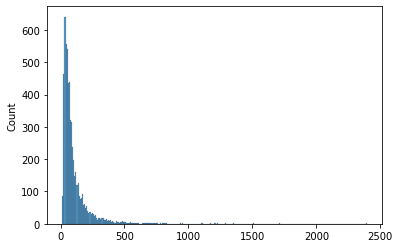

In [9]:
import seaborn as sns

sns.histplot(lens)

In [12]:
from collections import Counter

d = Counter(lens)
median = [0, 0]
for k, v in d.items():
    if v > median[1]:
        median = [k, v]
print(median)

[36, 91]


In [13]:
sum(list(d.values()))

5954

In [21]:
d[39]

83

In [10]:
# Quote List
quotes = list(df.quote)

# Corpus
text = ''
for q in quotes:
    text += ' ' + q
print("Corpus length:", len(text))
text = text.lower()

# Total Characters
chars = sorted(list(set(text)))
print("Total chars:", len(chars))

# Dictionaries
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# Number of sequences
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

Corpus length: 630844
Total chars: 52
Number of sequences: 210268


In [11]:
# Defining X and y
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

## 1.2. Building the Model

In [44]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [9]:
B_model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(maxlen, len(chars))),
        keras.layers.Bidirectional(layers.LSTM(128)),
        layers.Dense(len(chars), activation="softmax"),
        ])
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
B_model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [26]:
generator = keras.Sequential([
    keras.layers.InputLayer(input_shape=(maxlen, len(chars))),
    layers.LSTM(128),#, return_sequences=True),
    layers.Dense(len(chars), activation='relu'),
    layers.LeakyReLU(alpha=0.2)
])

generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               92672     
_________________________________________________________________
dense_5 (Dense)              (None, 52)                6708      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 52)                0         
Total params: 99,380
Trainable params: 99,380
Non-trainable params: 0
_________________________________________________________________


In [27]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
generator.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [10]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

## 1.3. Training the Model

In [46]:
epochs = 40
batch_size = 128

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print("...Diversity:", diversity)

        generated = ""
        sentence = text[start_index : start_index + maxlen]
        print('...Generating with seed: "' + sentence + '"')

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, temperature=diversity)
            next_char = indices_char[next_index]
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print()


...Generated:   you night, thent hole are fucking dashon plan! Potter open to a blackes. To the times... shand... and feel into the Can civatte, and you're going to servick the side. They make anything. And I don't make anyone wanna comes my neirk with rung so deal back of uncartre? This is your seeing like the bourno kik, phocwly getheag alright my drise was gonna not again thing over to buy the offest, but old

...Diversity: 1.2
...Generating with seed: " of perm maintenance that you are forbid"
...Generated:  . Wellohimle was the book of tking preeps thy write waathed. Tumblet. I got the comubbaly you always take ciss. Barconice? eye talking? if we have listen on the oictomat's inherition tires as much Sum forgevin's myself! I can't hel lay e, anesses, foutly wrongs  gh them posstr, , reach inseers to get horrib. She a makin' back I I am I? That's ago around. Ssigging. This willing I started him nigyes

1643/1643 [==============================] - 88s 54ms/step - loss: 1.3785

Gene

### Bidirectional training

In [28]:
epochs = 10
batch_size = 128

for epoch in range(epochs):
    generator.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print("...Diversity:", diversity)

        generated = ""
        sentence = text[start_index : start_index + maxlen]
        print('...Generating with seed: "' + sentence + '"')

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = generator.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print()

1643/1643 [==============================] - 82s 49ms/step - loss: nan

Generating text after epoch: 0
...Diversity: 0.2
...Generating with seed: "to end as long as this groundhog keeps s"


NameError: name 'sample' is not defined

In [13]:
B_model.save(root + os.sep + 'models' + os.sep + 'Bi_Char_Quote_Generator.h5')

# PARTE II. Word-Level Text Generation
## 2.1 Preprocesamiento

In [5]:
import pandas as pd
import numpy as np
import string
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [5]:
root = os.path.dirname(os.getcwd())
df = pd.read_csv(root + os.sep + 'data'+ os.sep + 'BASE.csv')

In [6]:
def column_to_text(df, column='quote'):
    quotes = list(df[column])
    text = ''
    for q in quotes:
        text += ' ' + q

    return text.lower()

In [7]:
# Obtenemos texto completo
text = column_to_text(df)

# Limpiamos el texto
def clean_doc(doc):
	# replace '--' with a space ' '
	doc = doc.replace('--', ' ')
	# split into tokens by white space
	tokens = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', string.punctuation)
	tokens = [w.translate(table) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# make lower case
	tokens = [word.lower() for word in tokens]
	return tokens

tokens = clean_doc(text)

# Mostramos datos
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

# Organizamos en secuencias de tokens
length = 50 + 1
sequences = []
for i in range(length, len(tokens)):
	# select sequence of tokens
	seq = tokens[i-length:i]
	# convert into a line
	line = ' '.join(seq)
	# store
	sequences.append(line)
print('Total Sequences: %d' % len(sequences))

Total Tokens: 118223
Unique Tokens: 11540
Total Sequences: 118172


In [8]:
sequences[0]

'who knocked up your sister i was watching you out there before ive never seen you look so sexy youre you dont know what you want and you wont know what you want til youre and even if you get it youll be too old to use it ooh see that'

In [8]:
# Encodeamos a enteros las secuencias
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sequences)
sequences = tokenizer.texts_to_sequences(sequences)

# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Dividimos en input(X) y output(y)
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

In [27]:
sequences.shape

(118172, 51)

## 2.2 Entrenando el Modelo

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# define model
model = keras.Sequential([
    layers.Embedding(vocab_size, 50, input_length=seq_length),
    layers.LSTM(100, return_sequences=True),
    layers.LSTM(100),
    layers.Dense(100, activation='relu'),
    layers.Dense(vocab_size, activation='softmax')
])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            577050    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 11541)             1165641   
Total params: 1,893,591
Trainable params: 1,893,591
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
model.fit(X, y, batch_size=128, epochs=10)

Epoch 1/10
924/924 [==============================] - 133s 141ms/step - loss: 6.8212 - accuracy: 0.0365
Epoch 2/10
924/924 [==============================] - 121s 130ms/step - loss: 6.4133 - accuracy: 0.0500
Epoch 3/10
924/924 [==============================] - 122s 132ms/step - loss: 6.1785 - accuracy: 0.0642
Epoch 4/10
924/924 [==============================] - 128s 139ms/step - loss: 6.0160 - accuracy: 0.0767
Epoch 5/10
924/924 [==============================] - 123s 133ms/step - loss: 5.8931 - accuracy: 0.0860
Epoch 6/10
924/924 [==============================] - 126s 136ms/step - loss: 5.7966 - accuracy: 0.0915
Epoch 7/10
924/924 [==============================] - 129s 140ms/step - loss: 5.7027 - accuracy: 0.0967
Epoch 8/10
924/924 [==============================] - 119s 129ms/step - loss: 5.6048 - accuracy: 0.1006
Epoch 9/10
924/924 [==============================] - 120s 130ms/step - loss: 5.5221 - accuracy: 0.1034
Epoch 10/10
924/924 [==============================] - 122s 133m

In [24]:
model.save(root + os.sep + 'models' + os.sep + 'Word_Base_Quote_Generator.h5')

## 3.1 Generación de texto

In [3]:
import tensorflow as tf
import os

import random
import numpy as np
import pandas as pd

import re
import nltk

root = os.path.dirname(os.getcwd())
df = pd.read_csv(root + os.sep + 'data'+ os.sep + 'BASE.csv')

word_model = tf.keras.models.load_model(root + os.sep + 'models' + os.sep + 'Word_Base_Quote_Generator.h5')

In [9]:
import random

# select a seed text
seed_text = str(sequences[random.randint(0,len(sequences))]) + '\n'
print(seed_text)


# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
	result = list()
	in_text = seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# truncate sequences to a fixed length
		encoded = tf.keras.preprocessing.sequence.pad_sequences([encoded], maxlen=seq_length, truncating='pre')
		# predict probabilities for each word
		yhat = np.argmax(model.predict(encoded), axis=-1)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
		result.append(out_word)
	return ' '.join(result)

[7492    2   53    4 4334    2   53    4  202 4335 1285   90   83   11
  109  211   66   41    4 7493  613  118  271    3   28    5 1140  191
 3114   51  271 2430 2430    3   85   41  242    7  243   24   11   16
 1166 1691  254  204  892  164    3  153   30]



In [13]:
# Resultado
generated = generate_seq(word_model, tokenizer, seq_length, seed_text, 50)
print(generated)

and i dont know that i dont know it i dont know it i dont know it i dont know it i dont know it i dont know it i dont know it i dont know it i dont know it i dont know it i dont know it i


# PARTE III. Diseñando una GAN

In [ ]:
from src.utils.models import CharacterPreprocessor

cp = CharacterPreprocessor(df)
cp.preprocess()

In [ ]:
X_true = cp.X
y_true = np.ones(len(cp.X))

## 3.1 Generador

In [ ]:
generator = keras.Sequential([
    keras.layers.InputLayer(input_shape=(cp.maxlen, len(cp.chars))),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(100),
    layers.Dropout(0.3)
    layers.Dense(100, activation='relu'),
    layers.Dense(len(cp.chars), activation="softmax")
])
#optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
#generator.compile(loss="categorical_crossentropy", optimizer=optimizer)

## 3.2 Discriminador

In [ ]:
discriminator = keras.Sequential([
    keras.layers.Conv1D(filters=40, kernel_size=3, input_shape=(cp.maxlen, len(cp.chars)), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu')
    keras.layers.Dense(1, activation='sigmoid')
])

#discriminator.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['acc'])

## 3.3 GAN

In [ ]:
gan = keras.Sequential([
    generator,
    discriminator
])

gan.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['acc'])

# PARTE IV. Otras aproximaciones

In [11]:
def using_Tokenizer(doc):
    # create the tokenizer
    t = Tokenizer()
    # fit the tokenizer on the documents
    t.fit_on_texts(doc)

    # integer encode documents
    encoded_docs = t.texts_to_matrix(doc, mode='count')
    return encoded_docs

def using_to_categorical(doc):
    label_encoder = LabelEncoder()
    data = label_encoder.fit_transform(doc)
    data = array(data)

    # one hot encode
    encoded = to_categorical(data)
    return encoded

def invert_encoding(row_num):
    inverted = label_encoder.inverse_transform([argmax(onehot_encoded[row_num, :])])
    return inverted

def column_to_text(df, column='quote'):
    quotes = list(df[column])
    text = ''
    for q in quotes:
        text += ' ' + q

    return text.lower()

In [6]:
df = pd.read_csv('BASE.csv')

In [12]:
text = column_to_text(df)